In [6]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')
REG_PATH = os.path.join(DATA_DIR, 'regression_dataset_v2.csv')

print("데이터 로드")
df_reg = pd.read_csv(REG_PATH)
print(f"회귀 데이터셋: {len(df_reg)}개")

print("\n[Linear Regression 모델 구축]")
print("y = a1*x1 + a2*x2 + a3*x3 + b")
print("  x1 (a1): doc_length (문서 크기)")
print("  x2 (a2): query_length (쿼리)")
print("  x3 (a3): dominant_topic (도메인)")

df_reg['doc_length_scaled'] = df_reg['doc_length'] / 1000
df_reg['query_length_scaled'] = df_reg['query_length']

results_summary = []
stats_summary = []
model_objects = {}

for model_name in ['BIM', 'BM25_Best']:
    print(f"{model_name} 모델")

    subset = df_reg[df_reg['model'] == model_name].copy()

    X = subset[['doc_length_scaled', 'query_length_scaled', 'dominant_topic']].values
    y = subset['search_score'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)

    ols_model = sm.OLS(y_train, X_train_sm)
    ols_result = ols_model.fit()

    print("\n[회귀 계수 및 통계적 유의성]")
    print(ols_result.summary())

    params = ols_result.params
    pvalues = ols_result.pvalues
    conf_int = ols_result.conf_int()
    tvalues = ols_result.tvalues

    b = params[0]
    a1, a2, a3 = params[1], params[2], params[3]

    print(f"\n회귀 계수:")
    print(f"  a1 (doc_length):      {a1:>10.6f}  (p={pvalues[1]:.4f}, t={tvalues[1]:.2f})")
    print(f"  a2 (query_length):    {a2:>10.6f}  (p={pvalues[2]:.4f}, t={tvalues[2]:.2f})")
    print(f"  a3 (dominant_topic):  {a3:>10.6f}  (p={pvalues[3]:.4f}, t={tvalues[3]:.2f})")
    print(f"  b  (intercept):       {b:>10.6f}  (p={pvalues[0]:.4f}, t={tvalues[0]:.2f})")

    print(f"\n95% 신뢰구간:")
    print(f"  a1: [{conf_int[1, 0]:.6f}, {conf_int[1, 1]:.6f}]")
    print(f"  a2: [{conf_int[2, 0]:.6f}, {conf_int[2, 1]:.6f}]")
    print(f"  a3: [{conf_int[3, 0]:.6f}, {conf_int[3, 1]:.6f}]")

    y_train_pred = ols_result.predict(X_train_sm)
    y_test_pred = ols_result.predict(X_test_sm)

    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n모델 성능:")
    print(f"  Train - R²: {train_r2:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
    print(f"  Test  - R²: {test_r2:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")

    print(f"\n모델 통계량:")
    print(f"  R²: {ols_result.rsquared:.4f}")
    print(f"  Adjusted R²: {ols_result.rsquared_adj:.4f}")
    print(f"  F-statistic: {ols_result.fvalue:.2f} (p={ols_result.f_pvalue:.4e})")
    print(f"  AIC: {ols_result.aic:.2f}")
    print(f"  BIC: {ols_result.bic:.2f}")

    results_summary.append({
        'Model': model_name,
        'a1_doc': a1,
        'a2_query': a2,
        'a3_topic': a3,
        'b_intercept': b,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_MSE': test_mse,
        'Test_MAE': test_mae,
        'Adj_R2': ols_result.rsquared_adj,
        'F_stat': ols_result.fvalue,
        'F_pvalue': ols_result.f_pvalue,
        'AIC': ols_result.aic,
        'BIC': ols_result.bic
    })

    stats_summary.append({
        'Model': model_name,
        'Variable': 'a1_doc_length',
        'Coefficient': a1,
        'Std_Error': ols_result.bse[1],
        'T_statistic': tvalues[1],
        'P_value': pvalues[1],
        'CI_Lower': conf_int[1, 0],
        'CI_Upper': conf_int[1, 1]
    })

    stats_summary.append({
        'Model': model_name,
        'Variable': 'a2_query_length',
        'Coefficient': a2,
        'Std_Error': ols_result.bse[2],
        'T_statistic': tvalues[2],
        'P_value': pvalues[2],
        'CI_Lower': conf_int[2, 0],
        'CI_Upper': conf_int[2, 1]
    })

    stats_summary.append({
        'Model': model_name,
        'Variable': 'a3_dominant_topic',
        'Coefficient': a3,
        'Std_Error': ols_result.bse[3],
        'T_statistic': tvalues[3],
        'P_value': pvalues[3],
        'CI_Lower': conf_int[3, 0],
        'CI_Upper': conf_int[3, 1]
    })

    model_objects[model_name] = {
        'model': ols_result,
        'y_train': y_train,
        'y_train_pred': y_train_pred,
        'y_test': y_test,
        'y_test_pred': y_test_pred
    }

df_results = pd.DataFrame(results_summary)
df_stats = pd.DataFrame(stats_summary)

데이터 로드
회귀 데이터셋: 27298개

[Linear Regression 모델 구축]
y = a1*x1 + a2*x2 + a3*x3 + b
  x1 (a1): doc_length (문서 크기)
  x2 (a2): query_length (쿼리)
  x3 (a3): dominant_topic (도메인)
BIM 모델

[회귀 계수 및 통계적 유의성]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     3527.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:59:43   Log-Likelihood:                -33261.
No. Observations:               10919   AIC:                         6.653e+04
Df Residuals:                   10915   BIC:                         6.656e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
             

    Model    a1_doc  a2_query  a3_topic  b_intercept
      BIM -0.024895  0.687804  0.062742     5.024997
BM25_Best  0.084683  1.320157  0.236747    10.638070

[통계적 유의성 분석]
    Model          Variable  Coefficient  Std_Error  T_statistic      P_value  CI_Lower  CI_Upper
      BIM     a1_doc_length    -0.024895   0.002378   -10.470378 1.561073e-25 -0.029556 -0.020235
      BIM   a2_query_length     0.687804   0.006689   102.833308 0.000000e+00  0.674693  0.700915
      BIM a3_dominant_topic     0.062742   0.017077     3.674126 2.398069e-04  0.029269  0.096216
BM25_Best     a1_doc_length     0.084683   0.018337     4.618257 3.914003e-06  0.048740  0.120627
BM25_Best   a2_query_length     1.320157   0.022547    58.551249 0.000000e+00  1.275960  1.364353
BM25_Best a3_dominant_topic     0.236747   0.057325     4.129894 3.656340e-05  0.124379  0.349115

[모델 성능 비교]
    Model  Test_R2   Adj_R2      F_stat          AIC
      BIM 0.498078 0.492116 3527.338847 66529.054736
BM25_Best 0.254455 0.24

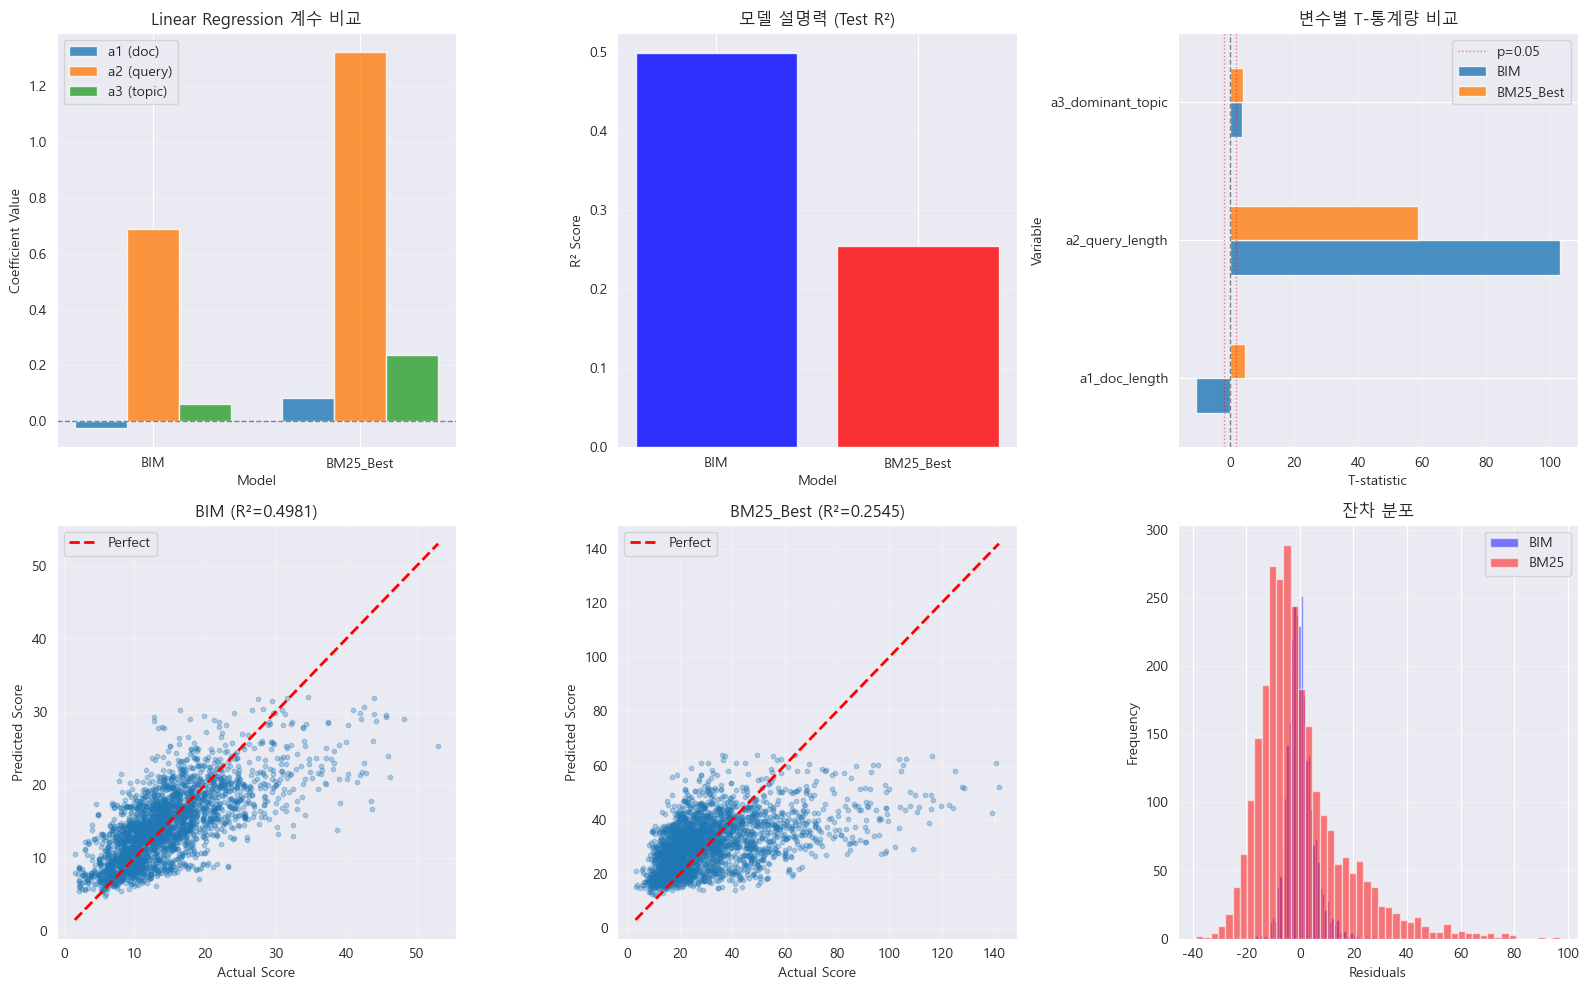


[결과 저장]

작업 완료
저장된 파일:
  - linear_regression_results_v4.csv
  - linear_regression_stats_v4.csv
  - linear_regression_v4.png


In [8]:
print(df_results[['Model', 'a1_doc', 'a2_query', 'a3_topic', 'b_intercept']].to_string(index=False))

print("\n[통계적 유의성 분석]")
print(df_stats.to_string(index=False))

print("\n[모델 성능 비교]")
print(df_results[['Model', 'Test_R2', 'Adj_R2', 'F_stat', 'AIC']].to_string(index=False))

print("\n[계수 해석]")
for _, row in df_results.iterrows():
    model = row['Model']
    a1 = row['a1_doc']
    a2 = row['a2_query']
    a3 = row['a3_topic']

    print(f"\n{model}:")

    stats_a1 = df_stats[(df_stats['Model'] == model) & (df_stats['Variable'] == 'a1_doc_length')].iloc[0]
    if stats_a1['P_value'] < 0.001:
        sig = "***"
    elif stats_a1['P_value'] < 0.01:
        sig = "**"
    elif stats_a1['P_value'] < 0.05:
        sig = "*"
    else:
        sig = "n.s."

    if a1 > 0:
        print(f"  a1={a1:.4f} {sig}: 문서 1k 증가 시 점수 {a1:.4f} 증가 (긴 문서 선호)")
    else:
        print(f"  a1={a1:.4f} {sig}: 문서 1k 증가 시 점수 {abs(a1):.4f} 감소 (짧은 문서 선호)")

    stats_a2 = df_stats[(df_stats['Model'] == model) & (df_stats['Variable'] == 'a2_query_length')].iloc[0]
    if stats_a2['P_value'] < 0.001:
        sig = "***"
    elif stats_a2['P_value'] < 0.01:
        sig = "**"
    elif stats_a2['P_value'] < 0.05:
        sig = "*"
    else:
        sig = "n.s."

    if a2 > 0:
        print(f"  a2={a2:.4f} {sig}: 쿼리 1 증가 시 점수 {a2:.4f} 증가")
    else:
        print(f"  a2={a2:.4f} {sig}: 쿼리 1 증가 시 점수 {abs(a2):.4f} 감소")

    stats_a3 = df_stats[(df_stats['Model'] == model) & (df_stats['Variable'] == 'a3_dominant_topic')].iloc[0]
    if stats_a3['P_value'] < 0.001:
        sig = "***"
    elif stats_a3['P_value'] < 0.01:
        sig = "**"
    elif stats_a3['P_value'] < 0.05:
        sig = "*"
    else:
        sig = "n.s."

    if abs(a3) < 0.01:
        print(f"  a3={a3:.4f} {sig}: 토픽 영향 거의 없음")
    elif a3 > 0:
        print(f"  a3={a3:.4f} {sig}: 토픽 ID 증가 시 점수 증가")
    else:
        print(f"  a3={a3:.4f} {sig}: 토픽 ID 증가 시 점수 감소")

    print(f"  *** p<0.001, ** p<0.01, * p<0.05, n.s. p>=0.05")

print("\n[시각화]")

plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
x = np.arange(len(df_results))
width = 0.25
plt.bar(x - width, df_results['a1_doc'], width, label='a1 (doc)', alpha=0.8)
plt.bar(x, df_results['a2_query'], width, label='a2 (query)', alpha=0.8)
plt.bar(x + width, df_results['a3_topic'], width, label='a3 (topic)', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression 계수 비교')
plt.xticks(x, df_results['Model'])
plt.legend()
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 2)
plt.bar(x, df_results['Test_R2'], alpha=0.8, color=['blue', 'red'])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('모델 설명력 (Test R²)')
plt.xticks(x, df_results['Model'])
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 3)
df_stats_pivot = df_stats.pivot(index='Variable', columns='Model', values='T_statistic')
df_stats_pivot.plot(kind='barh', ax=plt.gca(), alpha=0.8)
plt.xlabel('T-statistic')
plt.ylabel('Variable')
plt.title('변수별 T-통계량 비교')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=1.96, color='red', linestyle=':', linewidth=1, alpha=0.5, label='p=0.05')
plt.axvline(x=-1.96, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.legend()
plt.grid(axis='x', alpha=0.3)

for idx, (model_name, model_data) in enumerate(model_objects.items()):
    plt.subplot(2, 3, 4 + idx)

    y_test = model_data['y_test']
    y_test_pred = model_data['y_test_pred']

    plt.scatter(y_test, y_test_pred, alpha=0.3, s=10)

    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')

    r2 = r2_score(y_test, y_test_pred)

    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    plt.title(f'{model_name} (R²={r2:.4f})')
    plt.legend()
    plt.grid(alpha=0.3)

plt.subplot(2, 3, 6)
residuals_bim = model_objects['BIM']['y_test'] - model_objects['BIM']['y_test_pred']
residuals_bm25 = model_objects['BM25_Best']['y_test'] - model_objects['BM25_Best']['y_test_pred']

plt.hist(residuals_bim, bins=50, alpha=0.5, label='BIM', color='blue')
plt.hist(residuals_bm25, bins=50, alpha=0.5, label='BM25', color='red')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('잔차 분포')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'linear_regression_v4.png'), dpi=300)
plt.show()

print("\n[결과 저장]")
df_results.to_csv(os.path.join(DATA_DIR, 'linear_regression_results_v4.csv'), index=False)
df_stats.to_csv(os.path.join(DATA_DIR, 'linear_regression_stats_v4.csv'), index=False)

print("\n작업 완료")
print("저장된 파일:")
print("  - linear_regression_results_v4.csv")
print("  - linear_regression_stats_v4.csv")
print("  - linear_regression_v4.png")

---


데이터 로드
회귀 데이터셋: 27298개

Linear Regression 모델 구축
y = a1*x1 + a2*x2 + a3_1*topic1 + ... + a3_9*topic9 + b
  x1 (a1): doc_length (문서 크기)
  x2 (a2): query_length (쿼리)
  x3 (a3): dominant_topic (도메인, 더미 변수)

BIM 모델
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     981.0
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:07:42   Log-Likelihood:                -33206.
No. Observations:               10919   AIC:                         6.644e+04
Df Residuals:                   10907   BIC:                         6.652e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         


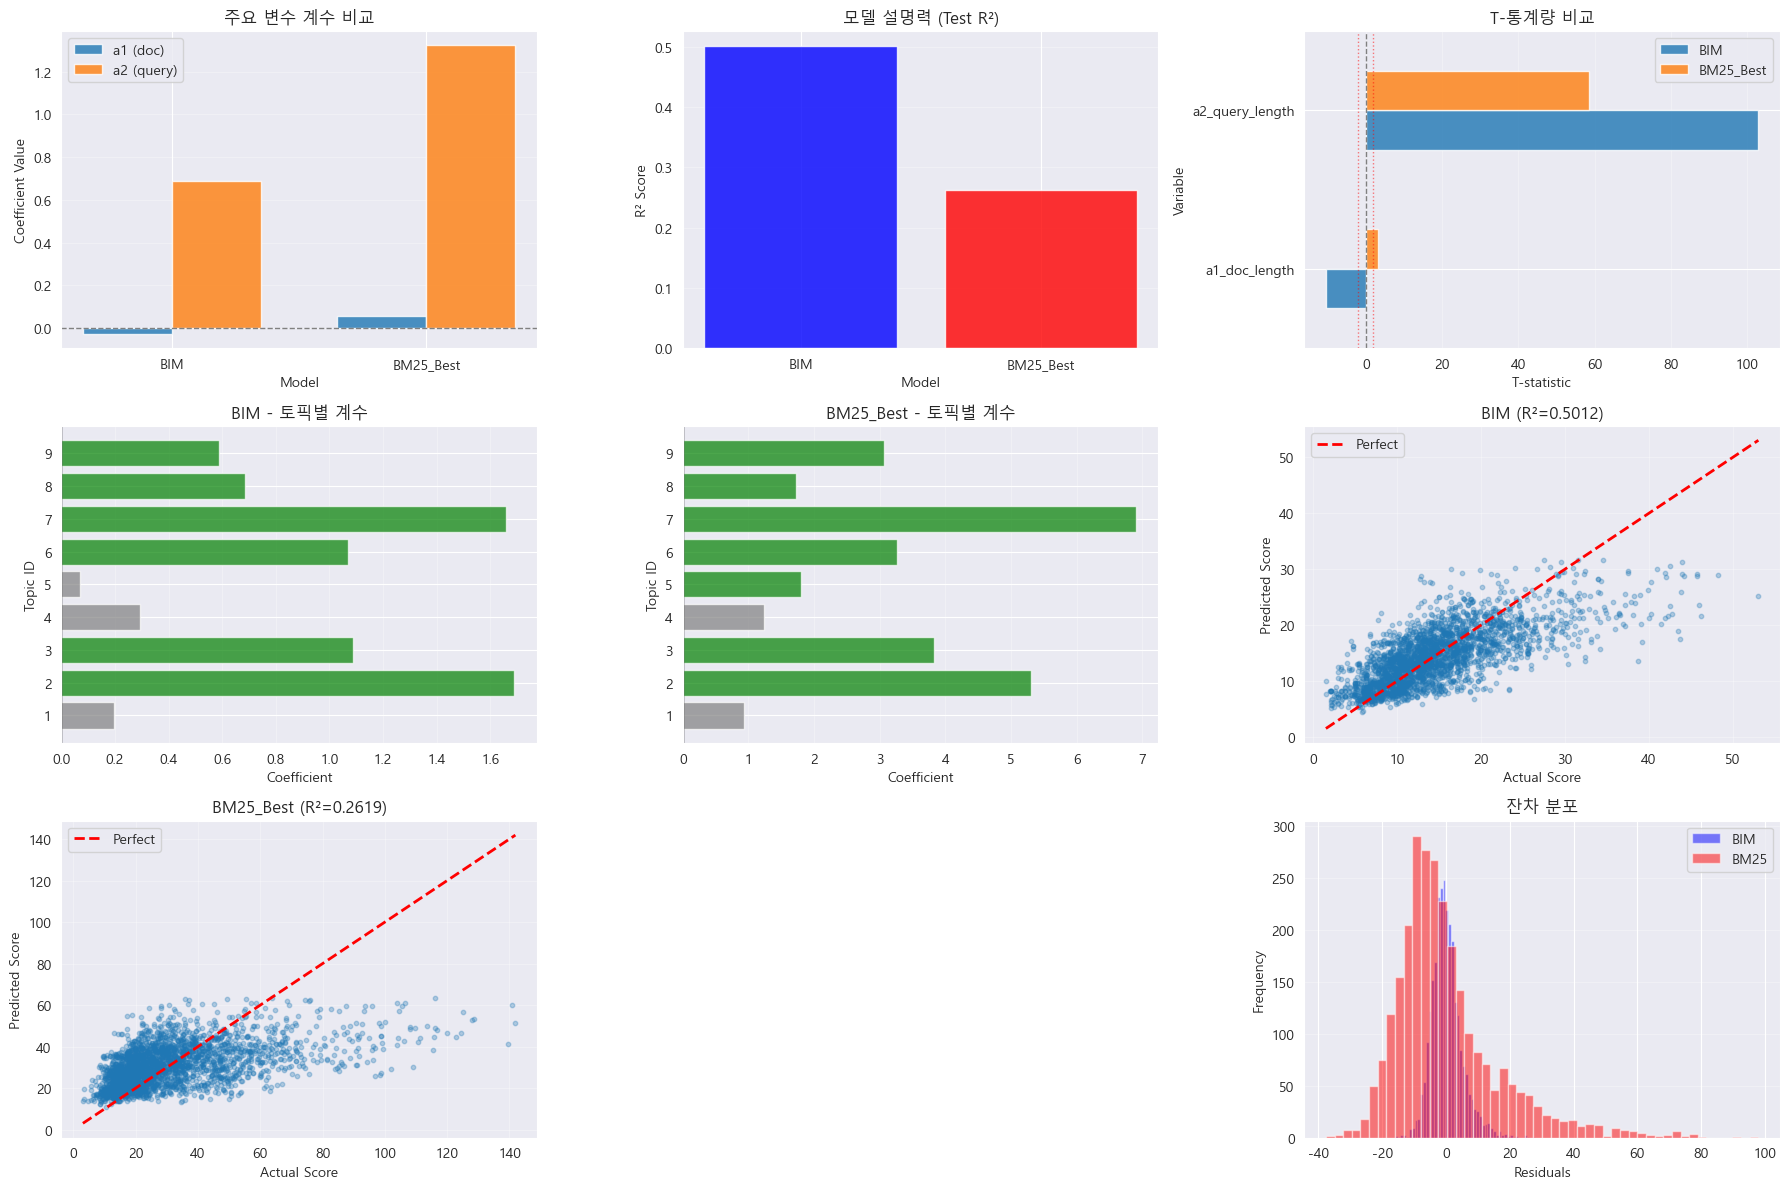


결과 저장

작업 완료
저장된 파일:
  - linear_regression_results_v5.csv
  - linear_regression_stats_v5.csv
  - linear_regression_topic_coefs_v5.csv
  - linear_regression_v5.png


In [12]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')
REG_PATH = os.path.join(DATA_DIR, 'regression_dataset_v2.csv')

print("데이터 로드")
df_reg = pd.read_csv(REG_PATH)
print(f"회귀 데이터셋: {len(df_reg)}개")

print("\nLinear Regression 모델 구축")
print("y = a1*x1 + a2*x2 + a3_1*topic1 + ... + a3_9*topic9 + b")
print("  x1 (a1): doc_length (문서 크기)")
print("  x2 (a2): query_length (쿼리)")
print("  x3 (a3): dominant_topic (도메인, 더미 변수)")

df_reg['doc_length_scaled'] = df_reg['doc_length'] / 1000
df_reg['query_length_scaled'] = df_reg['query_length']

results_summary = []
stats_summary = []
model_objects = {}
topic_coef_summary = []

for model_name in ['BIM', 'BM25_Best']:
    print(f"\n{model_name} 모델")

    subset = df_reg[df_reg['model'] == model_name].copy()

    X_cont = subset[['doc_length_scaled', 'query_length_scaled']].copy()
    topics_dummies = pd.get_dummies(subset['dominant_topic'], prefix='topic', drop_first=True)
    X = pd.concat([X_cont, topics_dummies], axis=1)

    X = X.astype(float)
    y = subset['search_score'].values.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_sm = sm.add_constant(X_train).astype(float)
    X_test_sm = sm.add_constant(X_test).astype(float)

    ols_model = sm.OLS(y_train, X_train_sm)
    ols_result = ols_model.fit()

    print(ols_result.summary())

    params = ols_result.params
    pvalues = ols_result.pvalues
    conf_int = ols_result.conf_int().values
    tvalues = ols_result.tvalues

    b = params[0]
    a1 = params[1]
    a2 = params[2]
    topic_coefs = params[3:]

    print(f"\n회귀 계수:")
    print(f"  a1 (doc_length):      {a1:>10.6f}  (p={pvalues[1]:.4f}, t={tvalues[1]:.2f})")
    print(f"  a2 (query_length):    {a2:>10.6f}  (p={pvalues[2]:.4f}, t={tvalues[2]:.2f})")
    print(f"  b  (intercept):       {b:>10.6f}  (p={pvalues[0]:.4f}, t={tvalues[0]:.2f})")

    print(f"\n토픽 계수 (topic 0 기준):")
    for i, (topic_name, coef) in enumerate(zip(topics_dummies.columns, topic_coefs)):
        topic_id = int(topic_name.split('_')[1])
        p_val = pvalues[3 + i]
        t_val = tvalues[3 + i]
        if p_val < 0.001:
            sig = "***"
        elif p_val < 0.01:
            sig = "**"
        elif p_val < 0.05:
            sig = "*"
        else:
            sig = "n.s."
        print(f"  a3_{topic_id}: {coef:>10.6f}  (p={p_val:.4f}, t={t_val:.2f}) {sig}")

        topic_coef_summary.append({
            'Model': model_name,
            'Topic': topic_id,
            'Coefficient': coef,
            'P_value': p_val,
            'T_statistic': t_val,
            'CI_Lower': conf_int[3 + i, 0],
            'CI_Upper': conf_int[3 + i, 1]
        })

    print(f"\n95% 신뢰구간:")
    print(f"  a1: [{conf_int[1, 0]:.6f}, {conf_int[1, 1]:.6f}]")
    print(f"  a2: [{conf_int[2, 0]:.6f}, {conf_int[2, 1]:.6f}]")

    y_train_pred = ols_result.predict(X_train_sm)
    y_test_pred = ols_result.predict(X_test_sm)

    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n모델 성능:")
    print(f"  Train - R²: {train_r2:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
    print(f"  Test  - R²: {test_r2:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")

    print(f"\n모델 통계량:")
    print(f"  R²: {ols_result.rsquared:.4f}")
    print(f"  Adjusted R²: {ols_result.rsquared_adj:.4f}")
    print(f"  F-statistic: {ols_result.fvalue:.2f} (p={ols_result.f_pvalue:.4e})")
    print(f"  AIC: {ols_result.aic:.2f}")
    print(f"  BIC: {ols_result.bic:.2f}")

    results_summary.append({
        'Model': model_name,
        'a1_doc': a1,
        'a2_query': a2,
        'b_intercept': b,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_MSE': test_mse,
        'Test_MAE': test_mae,
        'Adj_R2': ols_result.rsquared_adj,
        'F_stat': ols_result.fvalue,
        'F_pvalue': ols_result.f_pvalue,
        'AIC': ols_result.aic,
        'BIC': ols_result.bic
    })

    stats_summary.append({
        'Model': model_name,
        'Variable': 'a1_doc_length',
        'Coefficient': a1,
        'Std_Error': ols_result.bse[1],
        'T_statistic': tvalues[1],
        'P_value': pvalues[1],
        'CI_Lower': conf_int[1, 0],
        'CI_Upper': conf_int[1, 1]
    })

    stats_summary.append({
        'Model': model_name,
        'Variable': 'a2_query_length',
        'Coefficient': a2,
        'Std_Error': ols_result.bse[2],
        'T_statistic': tvalues[2],
        'P_value': pvalues[2],
        'CI_Lower': conf_int[2, 0],
        'CI_Upper': conf_int[2, 1]
    })

    model_objects[model_name] = {
        'model': ols_result,
        'y_train': y_train,
        'y_train_pred': y_train_pred,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'topic_coefs': topic_coefs,
        'topic_names': topics_dummies.columns.tolist()
    }

df_results = pd.DataFrame(results_summary)
df_stats = pd.DataFrame(stats_summary)
df_topic_coefs = pd.DataFrame(topic_coef_summary)

print("\n결과 요약")
print(df_results[['Model', 'a1_doc', 'a2_query', 'b_intercept']].to_string(index=False))

print("\n통계적 유의성 분석")
print(df_stats.to_string(index=False))

print("\n모델 성능 비교")
print(df_results[['Model', 'Test_R2', 'Adj_R2', 'F_stat', 'AIC']].to_string(index=False))

print("\n계수 해석")
for _, row in df_results.iterrows():
    model = row['Model']
    a1 = row['a1_doc']
    a2 = row['a2_query']

    print(f"\n{model}:")

    stats_a1 = df_stats[(df_stats['Model'] == model) & (df_stats['Variable'] == 'a1_doc_length')].iloc[0]
    if stats_a1['P_value'] < 0.001:
        sig = "***"
    elif stats_a1['P_value'] < 0.01:
        sig = "**"
    elif stats_a1['P_value'] < 0.05:
        sig = "*"
    else:
        sig = "n.s."

    if a1 > 0:
        print(f"  a1={a1:.4f} {sig}: 문서 1k 증가 시 점수 {a1:.4f} 증가 (긴 문서 선호)")
    else:
        print(f"  a1={a1:.4f} {sig}: 문서 1k 증가 시 점수 {abs(a1):.4f} 감소 (짧은 문서 선호)")

    stats_a2 = df_stats[(df_stats['Model'] == model) & (df_stats['Variable'] == 'a2_query_length')].iloc[0]
    if stats_a2['P_value'] < 0.001:
        sig = "***"
    elif stats_a2['P_value'] < 0.01:
        sig = "**"
    elif stats_a2['P_value'] < 0.05:
        sig = "*"
    else:
        sig = "n.s."

    if a2 > 0:
        print(f"  a2={a2:.4f} {sig}: 쿼리 1 증가 시 점수 {a2:.4f} 증가")
    else:
        print(f"  a2={a2:.4f} {sig}: 쿼리 1 증가 시 점수 {abs(a2):.4f} 감소")

    model_topic_coefs = df_topic_coefs[df_topic_coefs['Model'] == model]
    significant_topics = model_topic_coefs[model_topic_coefs['P_value'] < 0.05].sort_values('Coefficient', ascending=False)

    if len(significant_topics) > 0:
        print(f"  토픽 효과 (유의미한 토픽만, topic 0 기준):")
        for _, topic_row in significant_topics.iterrows():
            topic_id = topic_row['Topic']
            coef = topic_row['Coefficient']
            p_val = topic_row['P_value']
            if p_val < 0.001:
                sig = "***"
            elif p_val < 0.01:
                sig = "**"
            else:
                sig = "*"
            print(f"    Topic {topic_id}: {coef:+.4f} {sig}")
    else:
        print(f"  토픽 효과: 유의미한 토픽 없음")

    print(f"  *** p<0.001, ** p<0.01, * p<0.05, n.s. p>=0.05")

print("\n시각화")

fig = plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
x = np.arange(len(df_results))
width = 0.35
plt.bar(x - width/2, df_results['a1_doc'], width, label='a1 (doc)', alpha=0.8)
plt.bar(x + width/2, df_results['a2_query'], width, label='a2 (query)', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Coefficient Value')
plt.title('주요 변수 계수 비교')
plt.xticks(x, df_results['Model'])
plt.legend()
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 3, 2)
plt.bar(x, df_results['Test_R2'], alpha=0.8, color=['blue', 'red'])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('모델 설명력 (Test R²)')
plt.xticks(x, df_results['Model'])
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 3, 3)
df_stats_pivot = df_stats.pivot(index='Variable', columns='Model', values='T_statistic')
df_stats_pivot.plot(kind='barh', ax=plt.gca(), alpha=0.8)
plt.xlabel('T-statistic')
plt.ylabel('Variable')
plt.title('T-통계량 비교')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=1.96, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.axvline(x=-1.96, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.legend()
plt.grid(axis='x', alpha=0.3)

for idx, model_name in enumerate(['BIM', 'BM25_Best']):
    plt.subplot(3, 3, 4 + idx)

    model_topic_data = df_topic_coefs[df_topic_coefs['Model'] == model_name].sort_values('Topic')

    colors = ['green' if p < 0.05 else 'gray' for p in model_topic_data['P_value']]

    plt.barh(model_topic_data['Topic'].astype(str), model_topic_data['Coefficient'], color=colors, alpha=0.7)
    plt.xlabel('Coefficient')
    plt.ylabel('Topic ID')
    plt.title(f'{model_name} - 토픽별 계수')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='x', alpha=0.3)

for idx, (model_name, model_data) in enumerate(model_objects.items()):
    plt.subplot(3, 3, 6 + idx)

    y_test = model_data['y_test']
    y_test_pred = model_data['y_test_pred']

    plt.scatter(y_test, y_test_pred, alpha=0.3, s=10)

    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')

    r2 = r2_score(y_test, y_test_pred)

    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    plt.title(f'{model_name} (R²={r2:.4f})')
    plt.legend()
    plt.grid(alpha=0.3)

plt.subplot(3, 3, 9)
residuals_bim = model_objects['BIM']['y_test'] - model_objects['BIM']['y_test_pred']
residuals_bm25 = model_objects['BM25_Best']['y_test'] - model_objects['BM25_Best']['y_test_pred']

plt.hist(residuals_bim, bins=50, alpha=0.5, label='BIM', color='blue')
plt.hist(residuals_bm25, bins=50, alpha=0.5, label='BM25', color='red')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('잔차 분포')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'linear_regression_v5.png'), dpi=300)
plt.show()

print("\n결과 저장")
df_results.to_csv(os.path.join(DATA_DIR, 'linear_regression_results_v5.csv'), index=False)
df_stats.to_csv(os.path.join(DATA_DIR, 'linear_regression_stats_v5.csv'), index=False)
df_topic_coefs.to_csv(os.path.join(DATA_DIR, 'linear_regression_topic_coefs_v5.csv'), index=False)

print("\n작업 완료")
print("저장된 파일:")
print("  - linear_regression_results_v5.csv")
print("  - linear_regression_stats_v5.csv")
print("  - linear_regression_topic_coefs_v5.csv")
print("  - linear_regression_v5.png")